In [128]:
%run presentation_setup.py
%matplotlib ipympl

<img src="Figurer/NTNU_Logo.png" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Advanced applications of FIR filters

* **Course AIS2201 - Signal Processing**
* **Week 44, 2024**
* **Lecturer: Kai Erik Hoff**

# Disposition:

1. Wiener Filters - 
2. 

# Problem formulation

* A desired signal $s[n]$ is subjected to a distortion system $g[n]$, and buried in noise $v[n]$ before the sampled signal $x[n]$ is acquired.

[Figure]

* Mathematical description:
### $$ x[n] = s[n] * g[n] + v[n]$$


* How can we attempt to extract the desired signal $s[n]$ from the sampled data $x[n]$?

## Example:

# The Wiener Filter

* Aims to produce an estimate $\hat{s}[n] \approx s[n]$ by filtering the sampled data $x[n]$.

[figure]
* Deviation quantified as: $e[n] = \hat{s}[n]-s[n]$
    * In principle, $e[n] \rightarrow 0$ would imply perfect reconstruction

* But how is are the optimal filter coefficients identified?

# Mean squared error

* $e[n]=0$ not practically possible unless noise power also equals zero
* Mean Square Error (MSE)
$$E\left(|e[n]|^2\right) = E\left(|s[n] - h[n]*x[n]|^2\right)$$
    * Will be a quadratic funciton of filter impulse response vector $\vec{h} = [h[0], h[1], \ldots, h[M]]^T$
 
* Optimal filter $\vec{h}_{opt}$ identified by solving:
$$ \frac{\delta E\left(|e[n]|^2\right)}{\delta \vec{h}}=0 \tag{1}$$

![](Figures/advanced_fir/MMSE.png)

# Solution:

* The solution for equation $1$ in the previous slide can be described in the frequency domain as:
$$H_{opt}(\hat{\omega}) = \frac{S_{xs}(\hat{\omega})}{S_{xx}(\hat{\omega})}$$
    * $S_{xx}(\hat{\omega})$ is the *power spectral density* of $x[n]$.
    * $S_{xs}(\hat{\omega})$ is the *cross power spectral density* of $x[n]$ and $s[n]$.
    * The derivation of this solution is beyond the scope of the course.

## Denoising example I

* Estimate the frequency response best suited to reconstruct the signal $s[n] = \sin\left(2\pi \cdot 440 \cdot \frac{n}{f_s}\right)$ from a sampled signal $x[n] = s[n] + v[n]$ where $v[n]$ is White Gaussian Nise (WGN) with variance $\sigma_v^2 = 1$.
    * $f_s$ is 8000 samples/second.

In [146]:
import numpy as np
from IPython.display import Audio

# Signal generation
fs = 8000
t_n = np.linspace(0, 1, fs, endpoint=False)
s_n = np.sin(2*np.pi*440*t_n)
x_n = s_n + np.random.normal(loc=0, scale=1, size=fs)

Audio(x_n, rate=fs)

In [147]:
# Attempt to find wiener filter
import scipy.signal as sig
import matplotlib.pyplot as plt

h_len = 256 # number of filter taps
f_filt, P_xx = sig.csd(x_n, x_n, fs=fs, nperseg=h_len, noverlap=h_len//2)
f_filt, P_xs = sig.csd(x_n, s_n, fs=fs, nperseg=h_len, noverlap=h_len//2)
H_filt = P_xs/P_xx
h = np.fft.irfft(P_xs/P_xx*np.exp(-2j*np.pi*f_filt/fs*((h_len-1)/2)), n=h_len)*sig.windows.hamming(h_len)

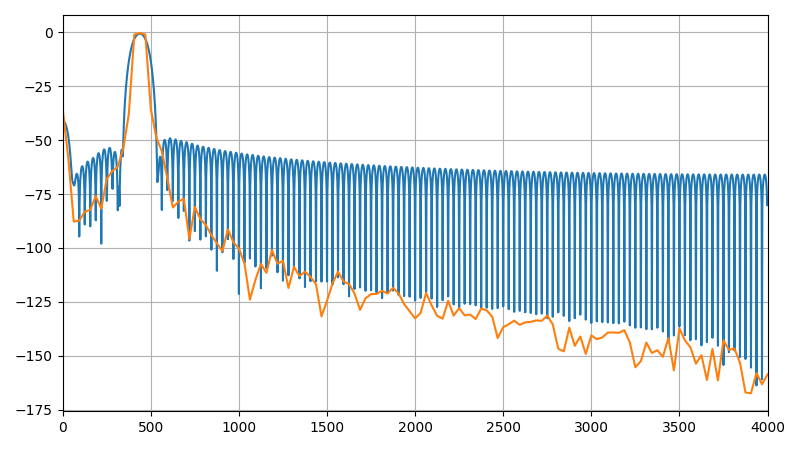

In [148]:
plt.figure()

f_filt2, Hf_filt2 = sig.freqz(h, 1, fs=fs, worN = h_len*8)
plt.plot(f_filt2,20*np.log10( np.abs(Hf_filt2)))
plt.plot(f_filt,20*np.log10( np.abs(P_xs/P_xx)))
#f_welch, Hf_welch = sig.welch(x, fs=fs, window="hamming", nperseg=2048, noverlap=1024, nfft=2048)

In [149]:
y_n = np.convolve(x_n, h)
Audio(y_n, rate=fs)

# Expanded solution:
$$H_{opt}(\hat{\omega}) = \frac{G(-\hat{\omega}) \cdot S_{ss}(\hat{\omega})}{|G(\hat{\omega})|^2\cdot S_{ss}(\hat{\omega}) + S_{vv}(\hat{\omega})}$$

* Assumes signal $s[n]$ and noise $v[n]$ are uncorrelated (generally true)
* $S_{ss}(\hat{\omega})$ is the signal Power Spectral Density (PSD)
* $S_{vv}(\hat{\omega})$ is the noise Power Spectral Density (PSD)

# Uses:
1. System identification
    * $s[n]$ and $x[n]$ are known, $g[n]$ is unknown
    * Noise PDF is estimated/assumed
2. Deconvolution
    * $g[n]$ and $x[n]$ are known, $s[n]$ is unknown
    * Noise PDF is estimated/assumed
3. Denoising
    * $g[n]$ is known, or assumes $G(\hat{\omega}) = 1$
    * Noise PDF is estimated/assumed
    * $x[n]$ is known

## Denoising example II

* Without prior knowledge of $s[n]$, estimate a wiener filter design which will remove the noise. The noise signal $v[n]$ can be assumed to be white gaussian noise.
    * Assuming a narrowband signal buried in white noise, the PSD median can be used as an estimate for noise level.

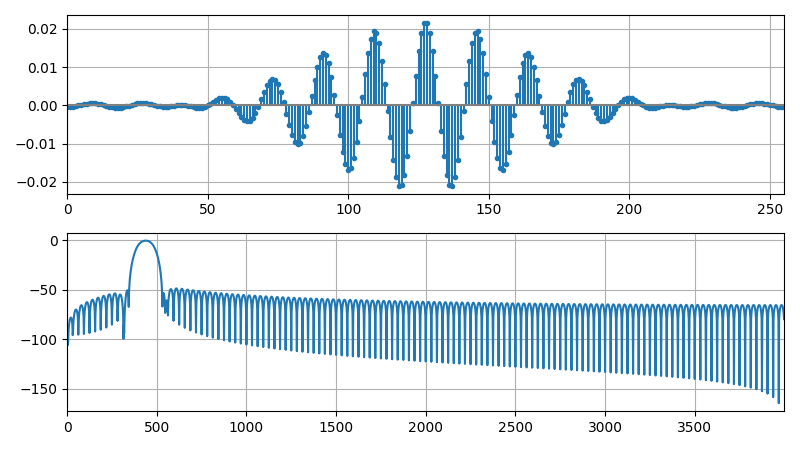

In [151]:
import numpy as np
from IPython.display import Audio

# Signal generation
fs = 8000
t_n = np.linspace(0, 1, fs, endpoint=False)
s_n = np.sin(2*np.pi*440*t_n)
x_n = s_n + np.random.normal(loc=0, scale=1, size=fs)

h_len = 256 # number of filter taps
f_filt, P_xx = sig.welch(x_n, fs=fs, nperseg=h_len, noverlap=h_len//2)  # Calculate PSD of x[n]

noise_floor = np.median(P_xx)  # Estimate noise level

P_vv = np.where(P_xx < noise_floor*1.5, P_xx, noise_floor)  # Separate noise PSD by setting a threshold for what constitutes a "signal"

P_ss = P_xx - P_vv  # Estimate PSD of s[n] by subtracting noise
H_filt = P_ss/(P_ss + P_vv)  # Calculate Wiener Filter Response H(f)
H_filt = H_filt * np.exp(-2j*np.pi*f_filt/fs*(h_len-1)/2)   # Add delay for causal filter
h_filt = np.fft.irfft(H_filt, n=h_len)  # Calculate desired filter frequency response
h_filt*= sig.windows.hamming(h_len)   # Apply window function
f_2, H_2 = sig.freqz(h_filt, 1, worN=8*h_len, fs=fs)  # Calculate acutal filter frequency response
plt.close(2); plt.figure(2)
plt.subplot(2,1,1)
plt.stem(h_filt, markerfmt='.', basefmt='grey')
plt.subplot(2,1,2)
plt.plot(f_2, 20*np.log10(np.abs(H_2)))

y_n = np.convolve(x_n, h_filt, mode="same")
Audio(y_n, rate=fs)

# Wiener filter limitations
* Assumes $x[n]$ can be modeled as a [Wide-Sense-Stationary](https://en.wikipedia.org/wiki/Stationary_process#Weak_or_wide-sense_stationarity) stochastic process. In simplified terms, this can be understood to mean:
    * Noise power $\sigma_v^2$ constant over the duration of the signal
    * The frequency content of $s[n]$ is constant over the duration of the signal
    * The distorting system $G(\hat{\omega})$ remains unchanged over the duration of the signal

#### Comments on designing wiener filters

* Frequency-domain filter design as described above can be problematic due to the [Gibbs phenomenon](https://en.wikipedia.org/wiki/Gibbs_phenomenon)
* Wiener filters more commonly designed by solving the [Wiener Hopf-equations](https://en.wikipedia.org/wiki/Wiener_filter#Finite_impulse_response_Wiener_filter_for_discrete_series), although this goes beyond the scope of this lecture.

# Adaptive filters


# Basic principle

[Figure]

1. Filter a sampled signal $x[n]$ using a *instantaneous* filter impulse response $\vec{h}[n]$ to produce an estimate $\hat{y}[n]$ of a desired output.
2. Calculate the error $e[n] = y[n] - \hat{y}[n]$
3. Use the error to update the next filter vector $\vec{h}[n+1]$

# Configuring an adaptive filter for prediction

[Figure]

* With optimal prediction, $e[n]$ becomes white uncorrelated noise.
    * White noise is by nature not predictable.
* The output of the predictor will be the remainder of the signal once white noise is removed.

## Prediction example
* Suggest a prediction filter impulse response $h[k]$ which can predict the next sample of a sinusoid which repeats every $8$ samples $\hat{\omega} = \frac{\pi}{4}$.

# Gradient descent

* Iterative optimization algorithm, can find the local minimum of a function (e.g. $f(x) = (x-3)^2 + 2$)
    * Also works when $x$ is a vector of $N$ independent values
* Algorithm:
$$ \vec{x}_{n+1} = \vec{x}_n - \mu \nabla f(\vec{x}_n) $$
    * $\mu$ is the step size
 
#### Example:

In [121]:
# Run cell once to initialize
import numpy as np
import matplotlib.pyplot as plt
f = lambda x: (x-3)**2+2  # Function to minimize
df = lambda x: 2*(x-3)*1  # Derivative of function

mu = 0.2  # step size

x_n = [0]   # Initial value

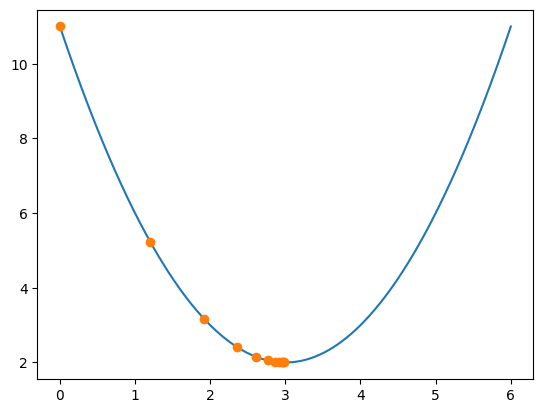

In [131]:
# Run repeatedly to observe gradient descent in 1D
x_next = x_n[-1] - mu*df(x_n[-1])
x_n.append(x_next)

x = np.linspace(0, 6, 501)
plt.plot(x, f(x))
plt.plot(x_n, f(np.array(x_n)), 'o')

# The LMS algorithm
* Gradient descent algorithm to find optimal filter coefficients $\vec{h}_{opt}$
    * Function to minimize: $E(|e[n]|^2) = F(\vec{h})$
    * Derivative of MSE: $\nabla F(\vec{h}) = -2\cdot e[n]\cdot \vec{h}_n$
 
* LMS Algorithm:
$$\vec{h}_{n+1} = \vec{h}_n + \mu \cdot 2 \cdot e[n] \cdot \vec{h}_n$$

# LMS algorithm flowchart

[Figure]

In [120]:
import scipy.signal as sig
# Initialize lms filter
M = 256
h = np.zeros(M)
x = np.concatenate((x_n, h))
y = np.zeros(len(x_n)+M)
mu = 0.01

alpha = 1

for i in range(len(x_n)):
    x_pred = 0
    x_pow = 0
    for j in range(M):
        x_pred += h[j]*x[i-j-1]
        x_pow += x[i-j-1]**2
    #x_pred = np.sum(x[i-M:i]*h[::-1])
    step_size = mu/(alpha+x_pow)
    err = x[i]-x_pred
    for j in range(M):
        h[j] += step_size*err*x[i-j-1]
    #h[::-1] += mu*err*x[i-M:i]
    y[i] = x_pred
f, Hf = sig.freqz(h, 1, fs=fs, worN = 8*M)
plt.close(4), plt.figure(4)
plt.plot(f, 20*np.log10(np.abs(Hf)))
plt.plot(f_filt2, 20*np.log10(np.abs(Hf_filt2)))

NameError: name 'fs' is not defined

In [43]:
Audio(y, rate=fs)

## The Wiener Filter

The [Wiener filter](https://en.wikipedia.org/wiki/Wiener_filter), named after [*Nobert Wiener*](https://en.wikipedia.org/wiki/Norbert_Wiener), aims at estimating an unknown random signal by filtering a noisy distorted observation of the signal. It has a wide range of applications in signal processing. For instance, noise reduction, system identification, deconvolution and signal detection. The Wiener filter is frequently used as basic building block for algorithms that denoise audio signals, like speech, or remove noise from a image.

### Signal Model

The following signal model is underlying the Wiener filter

![Illustration: Signal model for the Wiener filter](model_wiener_filter.png)

The random signal $s[k]$ is subject to distortion by the linear time-invariant (LTI) system $G(\mathrm{e}^{\,\mathrm{j}\,\Omega})$ and additive noise $n[k]$, resulting in the observed signal $x[k] = s[k] * g[k] + n[k]$. The additive noise $n[k]$ is assumed to be uncorrelated from $s[k]$. It is furthermore assumed that all random signals are wide-sense stationary (WSS). This distortion model holds for many practical problems, like e.g. the measurement of a physical quantity by a sensor.

The basic concept of the Wiener filter is to apply the LTI system $H(\mathrm{e}^{\,\mathrm{j}\,\Omega})$ to the observed signal $x[k]$ such that the output signal $y[k] = x[k] * h[k]$ matches $s[k]$ as close as possible. In order to quantify the deviation between $y[k]$ and $s[k]$, the error signal

\begin{equation}
e[k] = y[k] - s[k]
\end{equation}

is introduced. The error $e[k]$ equals zero, if the output signal $y[k]$ perfectly matches $s[k]$. In general, this goal cannot be achieved in a strict sense. As alternative one could aim at minimizing the linear average of the error $e[k]$. However, this quantity is not very well suited for optimization since it is signed. Instead, the quadratic average of the error $e[k]$ is used in the Wiener filter and other techniques. This measure is known as [*mean squared error*](https://en.wikipedia.org/wiki/Mean_squared_error) (MSE). It is defined as

\begin{equation}
E \{ |e[k]|^2 \} = \frac{1}{2 \pi} \int\limits_{-\pi}^{\pi} \Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) \,\mathrm{d}\Omega = \varphi_{ee}[\kappa] \Big\vert_{\kappa = 0}
\end{equation}

the equalities are deduced from the properties of the power spectral density (PSD) and the auto-correlation function (ACF). Above equation is referred to as [*cost function*](https://en.wikipedia.org/wiki/Loss_function). We aim at minimizing the cost function, hence minimizing the MSE between the original signal $s[k]$ and its estimate $y[k]$. The solution is referred to as [minimum mean squared error](https://en.wikipedia.org/wiki/Minimum_mean_square_error) (MMSE) solution.